# Probability Distribution Analysis of Forex Returns


Working directory: /Users/ortakhesap
Using CSV: /Users/ortakhesap/Desktop/syai/daily_forex_rates.csv


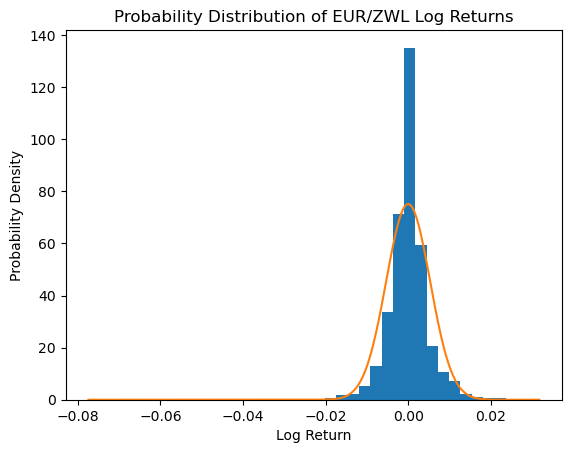

Selected currency pair: EUR/ZWL
Mean: -4.5467614261680085e-05
Std: 0.0053097741653138734
KS statistic: 0.11261235590069285
P-value: 2.552908625810733e-12
N: 1074


In [2]:
# =========================================================
# FOREX PROBABILITY DISTRIBUTION ANALYSIS (ROBUST + AUTO-FIND CSV)
# =========================================================

import numpy as np #lib for log
import pandas as pd #lib for csv reading
import matplotlib.pyplot as plt #lib for plotting
from scipy import stats #normalpdf kstest statistic
from pathlib import Path 

# ---------------------------------------------------------
# 0) FIND CSV (same folder OR subfolders)
# ---------------------------------------------------------
#If the csv pathname is not stable clear this code scans the whole computer to find csv files and path it and prints, links it
#do it manual normally if not working run this
PREFERRED_NAME = "daily_forex_rates.csv"

cwd = Path.cwd()
all_csvs = sorted(cwd.rglob("*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)

if not all_csvs:
    raise FileNotFoundError(
        f"No CSV found under: {cwd}\n"
        "Fix: move the CSV into this folder or provide CSV_PATH manually."
    )

preferred = [p for p in all_csvs if p.name.lower() == PREFERRED_NAME]
csv_path = preferred[0] if preferred else all_csvs[0]

print("Working directory:", cwd)
print("Using CSV:", csv_path)

# ---------------------------------------------------------
# 1) LOAD DATA
# ---------------------------------------------------------
#
df = pd.read_csv(csv_path) # load csv data to pandas dataframe

# Normalize column names, tidies the messed data 
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Map expected columns (in case of minor naming differences like close and price)
col_map_candidates = {
    "date": ["date", "datetime", "time", "timestamp"],
    "base_currency": ["base_currency", "base", "base_ccy"],
    "currency": ["currency", "quote_currency", "quote", "ccy"],
    "exchange_rate": ["exchange_rate", "rate", "value", "close"]
}

#helper func to stop crashing from messed code
def pick_col(expected):
    for cand in col_map_candidates[expected]:
        if cand in df.columns:
            return cand
    return None

#reassigning collumns
date_col = pick_col("date")
base_col = pick_col("base_currency")
curr_col = pick_col("currency")
rate_col = pick_col("exchange_rate")

#creates a list of missed failed to find data, stops the program and tells  if any missing to avoid crashes
missing = [k for k,v in [("date",date_col),("base_currency",base_col),("currency",curr_col),("exchange_rate",rate_col)] if v is None]
if missing:
    raise ValueError(f"Missing required columns: {missing}\nAvailable columns: {list(df.columns)}")
##buradan oncesi genel olarak messed data yuzunden cokmeleri engellemek adinaydi datasetten dolayi
    
    
# Parse date(converts date to actual python datetime object)
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Ensure numeric rate in exchange rates 
df[rate_col] = pd.to_numeric(df[rate_col], errors="coerce")

# ---------------------------------------------------------
# 2) CHECK AVAILABLE CURRENCY PAIRS
# ---------------------------------------------------------
pairs = df[[base_col, curr_col]].dropna().drop_duplicates() #small table of unique

if pairs.empty:
    raise ValueError("No currency pairs found (base/currency columns are empty).") #safety check for data

# Prefer USD/EUR if exists, else first available
want_base, want_curr = "USD", "EUR"
if not ((pairs[base_col] == want_base) & (pairs[curr_col] == want_curr)).any():
    base, curr = pairs.iloc[0, 0], pairs.iloc[0, 1]
else:
    base, curr = want_base, want_curr

# ---------------------------------------------------------
# 3) FILTER SELECTED PAIR
# ---------------------------------------------------------
fx = df[(df[base_col] == base) & (df[curr_col] == curr)].copy() # keep only rows matching our currency

fx = fx.dropna(subset=[date_col, rate_col]) #drop rows with date missing
fx = fx.sort_values(date_col) #sort data chronologically
fx = fx[fx[rate_col] > 0] # remove close prices with zero and below

# ---------------------------------------------------------
# 4) LOG RETURNS
# ---------------------------------------------------------
#doing the math ln(price today/price yesterday) 
#since they are repetitive and symetric log returns are preffered in finance (multiplying is used too much in finance however for math modelling and data adding is better so we transform it to log)
fx["log_return"] = np.log(fx[rate_col] / fx[rate_col].shift(1))
fx = fx.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_return"])

# ---------------------------------------------------------
# 5) CHECK DATA VALIDITY
# ---------------------------------------------------------
#final safety check looking if sd is zero or not
if fx.empty or fx["log_return"].std() == 0 or not np.isfinite(fx["log_return"].std()):
    raise ValueError("Log return data is empty or variance is zero. Distribution analysis not possible.")

# ---------------------------------------------------------
# 6) DESCRIPTIVE STATISTICS
# ---------------------------------------------------------
#Calculates the average return and the volatility (standard deviation)
mean_return = fx["log_return"].mean()
std_return = fx["log_return"].std()

# ---------------------------------------------------------
# 7) HISTOGRAM + NORMAL PDF
# ---------------------------------------------------------
#plots a histogram of the actual data
plt.figure()
plt.hist(fx["log_return"], bins=40, density=True)

x = np.linspace(fx["log_return"].min(), fx["log_return"].max(), 500) #Generates 500 evenly spaced numbers
pdf = stats.norm.pdf(x, mean_return, std_return) #Calculates the "Probability Density Function

plt.plot(x, pdf) #Draws the theoretical curve

#plot title laber specialisation. 
plt.title(f"Probability Distribution of {base}/{curr} Log Returns") 
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.show()

# ---------------------------------------------------------
# 8) KS NORMALITY TEST
# ---------------------------------------------------------

#performs the ks test and calculates the value. It compares the actual data distribution to the theoretical normal distribution.
#lower it is closer to a normal distribution, easier to make predictions and models
ks_stat, p_value = stats.kstest(
    fx["log_return"].to_numpy(),
    "norm",
    args=(mean_return, std_return)
)

# ---------------------------------------------------------
# 9) OUTPUT
# ---------------------------------------------------------
#setups the final statistics
print(f"Selected currency pair: {base}/{curr}")
print("Mean:", mean_return)
print("Std:", std_return)
print("KS statistic:", ks_stat)
print("P-value:", p_value)
print("N:", len(fx))


/Users/ortakhesap
[]
